In [1]:
import warnings
from arivale_data_interface import get_snapshot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch as mpatch
import seaborn as sns
from matplotlib import cm
import statsmodels.api as sm
from rich.progress import track
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from skbio.diversity import alpha,beta_diversity
warnings.simplefilter("ignore")
sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')
div = get_snapshot("microbiome_diversity")
div.head()

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/skbio/sequence/_sequence.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.Sequence, SkbioObject):
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/skbio/io/format/gff3.py:217: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


,public_client_id,vendor_observation_id,vendor_dashboard,client_id,vendor_research,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,...,observed_otus_30000,observed_otus_50000,shannon_100000,shannon_20000,shannon_30000,shannon_50000,simpson_100000,simpson_20000,simpson_30000,simpson_50000
0,01000261,AV15-1592,Second Genome,1966.0,amagis,77.0,3.0,12.0,Jan,Sun,...,930.0,1133.9,4.287808,4.258003,4.264935,4.280184,0.957,0.957,0.957,0.957
1,01001298,22001805511243,research-microbiome,275178.0,amagis,16.0,9.0,9.0,Sep,Thu,...,494.3,596.4,4.006391,3.986289,3.993914,4.000846,0.954,0.954,0.954,0.954
2,01001621,22001612562075,research-microbiome,185773.0,amagis,186.0,144.0,175.0,Jan,Mon,...,453.8,545.2,3.849739,3.832411,3.844887,3.847660,0.955,0.955,0.955,0.955
3,01001661,22001612561628,research-microbiome,177541.0,amagis,20.0,6.0,-4.0,Jun,Mon,...,453.9,560.6,NaN,3.732598,3.736063,3.740222,NaN,0.937,0.937,0.937
4,01001798,22001805510925,research-microbiome,278782.0,amagis,12.0,7.0,9.0,Jan,Mon,...,581.1,720.5,3.835876,3.814389,3.826866,3.833797,0.951,0.951,0.951,0.951


In [2]:
growth_rates= pd.read_pickle('Arivale_cdiff_growth_rates_tradeoff_pfba.pkl').reset_index()
cdiff=growth_rates[growth_rates.compartments=='Clostridioides']
cdiff['vendor_observation_id']=[x.split('|')[0] for x in cdiff['sample']]
cdiff

,compartments,growth_rate,abundance,sample,tradeoff,vendor_observation_id
2,Clostridioides,5.107642e-02,0.100148,22001612560033|GFM-1079-001,0.8,22001612560033
14,Clostridioides,1.198525e-01,0.100023,22001612560015|GFM-1079-015,0.8,22001612560015
30,Clostridioides,2.649423e-01,0.099917,22001612560045|GFM-1079-021,0.8,22001612560045
53,Clostridioides,1.772731e-07,0.100177,22001612560020|GFM-1079-003,0.8,22001612560020
76,Clostridioides,2.304020e-01,0.100398,22001612560012|GFM-1079-011,0.8,22001612560012
...,...,...,...,...,...,...
136515,Clostridioides,1.131604e-11,0.099936,AV15-4376|AKE035,0.8,AV15-4376
136545,Clostridioides,1.417002e-01,0.100023,QIRL|AKE014,0.8,QIRL
136567,Clostridioides,2.756182e-06,0.100024,AV15-4379|AKE036,0.8,AV15-4379
136595,Clostridioides,1.745178e-01,0.099904,NEBZ-2|AKE016,0.8,NEBZ-2


In [3]:
shannon={}
otus={}
simpson={}
for smp,df in growth_rates.groupby(by='sample'):
    df=df[~df.compartments.isin(['Clostridioides','community'])]
    df.abundance=df.abundance/df.abundance.sum()
    otus[smp]= alpha.observed_otus(df.abundance)
    simpson[smp]= alpha.simpson_e(df.abundance)
    shannon[smp]= alpha.shannon(df.abundance)
growth_rates['shannon']=growth_rates['sample'].map(shannon)
growth_rates['otus']=growth_rates['sample'].map(otus)
growth_rates['simpson']=growth_rates['sample'].map(simpson)
growth_rates

,compartments,growth_rate,abundance,sample,tradeoff,shannon,otus,simpson
0,Bifidobacterium,0.005594,0.010882,22001612560033|GFM-1079-001,0.8,0.642374,8,0.149216
1,Blautia,0.011947,0.023239,22001612560033|GFM-1079-001,0.8,0.642374,8,0.149216
2,Clostridioides,0.051076,0.100148,22001612560033|GFM-1079-001,0.8,0.642374,8,0.149216
3,Collinsella,0.004312,0.008484,22001612560033|GFM-1079-001,0.8,0.642374,8,0.149216
4,Enterocloster,0.046364,0.011066,22001612560033|GFM-1079-001,0.8,0.642374,8,0.149216
...,...,...,...,...,...,...,...,...
136636,Phocaeicola,0.221028,0.029271,QIRL-2|AKE014,0.8,2.984695,23,0.175883
136637,Roseburia,0.007843,0.004116,QIRL-2|AKE014,0.8,2.984695,23,0.175883
136638,Ruminococcus,0.006319,0.022639,QIRL-2|AKE014,0.8,2.984695,23,0.175883
136639,Streptococcus,0.000975,0.008461,QIRL-2|AKE014,0.8,2.984695,23,0.175883


In [5]:
clients = get_snapshot("clients")[["public_client_id", "sex", "age"]]
measure = pd.merge(measure, clients, on="public_client_id", how="inner")

weights = get_snapshot("weight")[["BMI_CALC", "public_client_id", "days_in_program"]].dropna()
measure = pd.merge_asof(
    measure[measure.public_client_id.isin(weights.public_client_id)].sort_values(by="days_in_program"), 
    weights.sort_values(by="days_in_program"), 
    by="public_client_id", on="days_in_program", direction="nearest")

measure=pd.merge(measure,cdiff,on='vendor_observation_id',how='inner')
measure

,diversity_shannon,vendor_observation_id,public_client_id,days_in_program,vendor_dashboard,sex,age,BMI_CALC,compartments,growth_rate,abundance,sample,tradeoff
0,3.870313,AV15-4372,01602320,-2.0,Second Genome,M,48.0,37.229730,Clostridioides,9.697649e-02,0.100091,AV15-4372|AKE035,0.8
1,4.281822,AV15-3716,01228476,0.0,Second Genome,F,51.0,22.462722,Clostridioides,3.016348e-01,0.100136,AV15-3716|AKE025,0.8
2,4.278019,AV15-1348,01306924,1.0,Second Genome,M,56.0,26.541837,Clostridioides,1.358488e-02,0.099909,AV15-1348|AKE011,0.8
3,4.283908,AV15-1295,01421882,1.0,Second Genome,F,19.0,23.793846,Clostridioides,1.810336e-01,0.100000,AV15-1295|AKE009,0.8
4,3.318960,AV15-3588,01949838,1.0,Second Genome,F,32.0,25.328546,Clostridioides,1.382353e-06,0.100067,AV15-3588|AKE025,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,3.868454,22001805521073,01441946,1367.0,research-microbiome,F,44.0,19.732234,Clostridioides,4.959075e-06,0.100022,22001805521073|GFM-1079-043,0.8
5073,4.627451,22001805520179,01152098,1368.0,research-microbiome,F,54.0,21.077601,Clostridioides,2.813894e-01,0.100202,22001805520179|GFM-1079-043,0.8
5074,4.207403,22001805510387,01023946,1371.0,research-microbiome,F,43.0,27.259184,Clostridioides,7.670708e-07,0.100068,22001805510387|GFM-1079-044,0.8
5075,4.273946,22001805521617,01483778,1377.0,research-microbiome,F,39.0,23.440253,Clostridioides,2.021650e-06,0.100342,22001805521617|GFM-1079-044,0.8


In [6]:
measure['log_growth'] = np.log10(measure['growth_rate'])
measure['growth_cat']=0
idx=measure[measure.log_growth>=-3].index.values
measure.loc[idx,'growth_cat']=1
measure['growth_cat'].unique()
measure

,diversity_shannon,vendor_observation_id,public_client_id,days_in_program,vendor_dashboard,sex,age,BMI_CALC,compartments,growth_rate,abundance,sample,tradeoff,log_growth,growth_cat
0,3.870313,AV15-4372,01602320,-2.0,Second Genome,M,48.0,37.229730,Clostridioides,9.697649e-02,0.100091,AV15-4372|AKE035,0.8,-1.013334,1
1,4.281822,AV15-3716,01228476,0.0,Second Genome,F,51.0,22.462722,Clostridioides,3.016348e-01,0.100136,AV15-3716|AKE025,0.8,-0.520519,1
2,4.278019,AV15-1348,01306924,1.0,Second Genome,M,56.0,26.541837,Clostridioides,1.358488e-02,0.099909,AV15-1348|AKE011,0.8,-1.866944,1
3,4.283908,AV15-1295,01421882,1.0,Second Genome,F,19.0,23.793846,Clostridioides,1.810336e-01,0.100000,AV15-1295|AKE009,0.8,-0.742241,1
4,3.318960,AV15-3588,01949838,1.0,Second Genome,F,32.0,25.328546,Clostridioides,1.382353e-06,0.100067,AV15-3588|AKE025,0.8,-5.859381,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,3.868454,22001805521073,01441946,1367.0,research-microbiome,F,44.0,19.732234,Clostridioides,4.959075e-06,0.100022,22001805521073|GFM-1079-043,0.8,-5.304599,0
5073,4.627451,22001805520179,01152098,1368.0,research-microbiome,F,54.0,21.077601,Clostridioides,2.813894e-01,0.100202,22001805520179|GFM-1079-043,0.8,-0.550692,1
5074,4.207403,22001805510387,01023946,1371.0,research-microbiome,F,43.0,27.259184,Clostridioides,7.670708e-07,0.100068,22001805510387|GFM-1079-044,0.8,-6.115165,0
5075,4.273946,22001805521617,01483778,1377.0,research-microbiome,F,39.0,23.440253,Clostridioides,2.021650e-06,0.100342,22001805521617|GFM-1079-044,0.8,-5.694294,0


Text(2.25, 0.5, 'log $C. diff$ growth')

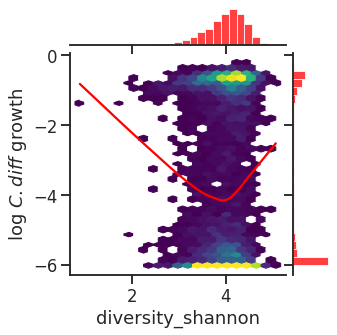

In [14]:
colors=sns.color_palette('colorblind')

lowess = sm.nonparametric.lowess
temp = measure.copy()
idx=temp[temp.log_growth < -6].index.values
temp.loc[idx,'log_growth']=-6
fit=lowess(temp.log_growth,temp.diversity_shannon)
my_viridis = cm.get_cmap("viridis", 1024).with_extremes(under="white")
sns.jointplot(x='diversity_shannon', y='log_growth', kind="hex", palette="viridis",data=temp,height=5,gridsize=(20,20),joint_kws={'vmin':1,'vmax':100,'cmap':my_viridis},marginal_kws={'bins':25,'color':'red'})
#plt.ylim(-6.2,1)
#plt.xlim(.75,4.5)
plt.plot(fit[:,0],fit[:,1],color='red')
plt.ylabel('log $C. diff$ growth')

## Blood metabolites

In [7]:
metabolites = get_snapshot("metabolomics_corrected").sort_values(by="days_in_program")
measure = measure.sort_values(by="days_in_program")
metabolite_features = metabolites.columns[8:]
metabolites.days_in_program = metabolites.days_in_program.astype("float64")

In [8]:
metabolites_merged = pd.merge_asof(
    measure, metabolites, 
    by="public_client_id", 
    on="days_in_program", 
    direction="nearest", 
    tolerance=30.0).dropna(subset=metabolite_features, how="all")
metabolite_features = metabolites.columns[metabolites.columns.isin(metabolite_features)]
metabolites_merged

,diversity_shannon,vendor_observation_id,public_client_id,days_in_program,vendor_dashboard,sex,age,BMI_CALC,compartments,growth_rate,...,999953114,999953157,999953172,999953266,999953267,999954831,999954832,999954834,999954839,999954840
5,4.542282,AV15-3636,01447446,1.0,Second Genome,F,56.0,21.950816,Clostridioides,1.022228e-07,...,NaN,NaN,NaN,1.522402,1.073743,1.063270,1.146081,0.942299,1.696602,1.564450
8,4.403993,AV15-1094,01789546,1.0,Second Genome,F,87.0,18.692937,Clostridioides,1.670734e-01,...,1.153663,0.658271,0.338122,1.162175,1.845431,0.963192,0.942735,0.961368,0.650608,1.703106
9,3.318960,AV15-3588,01949838,1.0,Second Genome,F,32.0,25.328546,Clostridioides,1.382353e-06,...,0.714835,1.276385,NaN,0.759459,1.205369,1.023168,1.106427,0.968127,NaN,1.118569
10,4.283908,AV15-1295,01421882,1.0,Second Genome,F,19.0,23.793846,Clostridioides,1.810336e-01,...,1.147181,0.758275,1.814588,3.996297,0.935515,0.915287,0.867081,0.871120,1.224561,NaN
11,4.278019,AV15-1348,01306924,1.0,Second Genome,M,56.0,26.541837,Clostridioides,1.358488e-02,...,1.528782,1.606430,1.125981,0.896099,0.838319,1.023423,1.075749,1.051521,0.766951,1.026390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464,3.684504,AV15-2674,01801678,453.0,Second Genome,M,35.0,20.705900,Clostridioides,7.248393e-07,...,0.514679,NaN,0.768327,1.997009,1.036581,NaN,NaN,NaN,NaN,0.570969
4481,2.850451,AV15-2217,01874590,463.0,Second Genome,M,36.0,21.558261,Clostridioides,2.416004e-01,...,NaN,NaN,1.382292,0.963556,1.770288,NaN,NaN,NaN,NaN,0.829983
4547,3.914202,22001805511808,01941857,509.0,research-microbiome,M,54.0,22.148708,Clostridioides,2.970213e-01,...,NaN,1.016756,NaN,1.035061,0.566952,NaN,NaN,NaN,1.032233,1.101631
4564,4.352964,22001612561459,01524770,517.0,research-microbiome,F,53.0,21.797160,Clostridioides,2.880267e-01,...,1.649832,1.048798,3.931804,1.391538,1.358102,NaN,NaN,NaN,NaN,0.490642


In [9]:
bad = metabolites_merged[metabolite_features].isnull().sum() / metabolites_merged.shape[0] > 0.25
metabolite_features = bad[~bad].index
metabolites_merged = metabolites_merged.drop(columns=bad[bad].index)
metabolites_merged.shape

(1777, 936)

In [10]:
metabolites_merged[metabolite_features] = np.log(metabolites_merged[metabolite_features])
metabolites_merged[metabolite_features] = metabolites_merged[metabolite_features].apply(lambda x: (x - x.mean()) / x.std())
metabolites_merged.rename(columns=dict(zip(metabolite_features, "metabolite_" + metabolite_features)), inplace=True)
metabolite_features = "metabolite_" + metabolite_features

In [11]:

def get_results(feature):
    """Get a single association.
    
    As long as `args` and `df` are assigned this can be used on
    any data set.
    """
    try:
        formula = f"{feature} ~ C(sex) + age + BMI_CALC + C(vendor_dashboard) + C(growth_cat)"
        fitted = ols(formula, data=df).fit()
        return pd.DataFrame({
            "feature": feature,
            "beta": fitted.params['C(growth_cat)[T.1]'],
            "se": fitted.HC0_se['C(growth_cat)[T.1]'],
            "t_statistic": fitted.tvalues['C(growth_cat)[T.1]'],
            "p": fitted.pvalues['C(growth_cat)[T.1]'],
            "n": fitted.nobs
            }, index=[feature])
    except:
        return pd.DataFrame({
            "feature": feature,
            "beta": np.nan,
            "se": np.nan,
            "t_statistic": np.nan,
            "p": np.nan,
            "n": np.nan
            }, index=[feature])

args = metabolite_features
df = metabolites_merged
df['growth_cat']=df['growth_cat'].astype(str)
results = map(get_results, args)
results = list(results)
tests = pd.concat(results)
tests=tests.iloc[:,:-1].dropna()
tests["q"] = multipletests(tests.p, method="fdr_bh")[1]
tests

,feature,beta,se,t_statistic,p,q
metabolite_35,metabolite_35,0.098411,0.049548,1.996283,0.046072,0.572024
metabolite_50,metabolite_50,-0.028645,0.050664,-0.560694,0.575087,0.911473
metabolite_55,metabolite_55,-0.046307,0.049556,-0.940406,0.347145,0.877183
metabolite_62,metabolite_62,0.031164,0.049542,0.624019,0.532709,0.911473
metabolite_93,metabolite_93,-0.061163,0.048500,-1.256892,0.208968,0.793225
...,...,...,...,...,...,...
metabolite_999952867,metabolite_999952867,0.107581,0.046640,2.263975,0.023722,0.521743
metabolite_999952877,metabolite_999952877,-0.149667,0.048576,-3.096789,0.001989,0.272719
metabolite_999952909,metabolite_999952909,-0.010023,0.045900,-0.217697,0.827692,0.945504
metabolite_999953157,metabolite_999953157,0.001960,0.048583,0.039479,0.968513,0.996962


In [24]:
tests=tests.iloc[:,:-1].dropna()
tests["q"] = multipletests(tests.p, method="fdr_bh")[1]
tests

,feature,beta,se,t_statistic,p,q,CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB
0,metabolite_35,0.098411,0.049548,1.996283,0.046072,0.517060,35,Glutamate Metabolism,Amino Acid,S-1-pyrroline-5-carboxylate,2906-39-0,C04322,HMDB01301
1,metabolite_50,-0.028645,0.050664,-0.560694,0.575087,0.926437,50,Polyamine Metabolism,Amino Acid,spermidine,124-20-9,C00315,HMDB01257
2,metabolite_55,-0.046307,0.049556,-0.940406,0.347145,0.909718,55,Nicotinate and Nicotinamide Metabolism,Cofactors and Vitamins,1-methylnicotinamide,1005-24-9,C02918,HMDB00699
3,metabolite_62,0.031164,0.049542,0.624019,0.532709,0.926437,62,"Fatty Acid, Dihydroxy",Lipid,"12,13-DiHOME",263399-35-5,C14829,HMDB04705
4,metabolite_93,-0.061163,0.048500,-1.256892,0.208968,0.798230,93,TCA Cycle,Energy,alpha-ketoglutarate,305-72-6;328-50-7;22202-68-2,C00026,HMDB00208
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,metabolite_100003397,-0.047171,0.047417,-0.984212,0.325152,0.908413,100003397,Phospholipid Metabolism,Lipid,trimethylamine N-oxide,1184-78-7,C01104,HMDB00925
456,metabolite_100003473,0.014932,0.054634,0.273984,0.784138,0.926437,100003473,Food Component/Plant,Xenobiotics,alliin,556-27-4,C08265,HMDB33592
658,metabolite_100010955,-0.057949,0.043962,-1.303297,0.192654,0.798230,100010955,Chemical,Xenobiotics,perfluorooctanesulfonate (PFOS),1763-23-1,C18142,HMDB59586
706,metabolite_100016038,-0.016188,0.049354,-0.325009,0.745216,0.926437,100016038,Polyamine Metabolism,Amino Acid,(N(1) + N(8))-acetylspermidine,14278-49-0,C00612,HMDB01276


In [14]:
anns = get_snapshot("metabolomics_metadata").iloc[:, 0:8]
anns["feature"] = "metabolite_" + anns.CHEMICAL_ID.astype(str)
tests = pd.merge(tests, anns, on="feature")

In [15]:
tests.sort_values(by='p').dropna()

,feature,beta,se,t_statistic,p,q,CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM
425,metabolite_100002488,-0.184034,0.049334,-3.708634,0.000215,0.080506,100002488,Secondary Bile Acid Metabolism,Lipid,isoursodeoxycholate,78919-26-3,C17662,HMDB00686,127601.0
355,metabolite_100001657,0.182064,0.049912,3.656142,0.000264,0.080506,100001657,Secondary Bile Acid Metabolism,Lipid,glycolithocholate sulfate*,15324-64-8,C11301,HMDB02639,72222.0
356,metabolite_100001658,0.162699,0.049682,3.255827,0.001154,0.211099,100001658,Secondary Bile Acid Metabolism,Lipid,taurolithocholate 3-sulfate,64936-83-0,C03642,HMDB02580,440071.0
28,metabolite_250,-0.147290,0.047449,-3.082456,0.002086,0.272719,250,Hemoglobin and Porphyrin Metabolism,Cofactors and Vitamins,biliverdin,55482-27-4;55482-27-4,C00500,HMDB01008,5353439.0
172,metabolite_100000042,-0.142743,0.050208,-2.884017,0.003976,0.366373,100000042,Histidine Metabolism,Amino Acid,3-methylhistidine,368-16-1,C01152,HMDB00479,64969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,metabolite_100001002,-0.001503,0.048824,-0.030852,0.975391,0.996962,100001002,Chemical,Xenobiotics,EDTA,60-00-4,C00284,HMDB15109,6049.0
296,metabolite_100001399,0.001310,0.051101,0.025742,0.979467,0.996962,100001399,Xanthine Metabolism,Xenobiotics,"1,7-dimethylurate",33868-03-0,C16356,HMDB11103,91611.0
217,metabolite_100000900,0.001019,0.053808,0.020497,0.983649,0.996962,100000900,Chemical,Xenobiotics,iminodiacetate (IDA),142-73-4,C19911,HMDB11753,8897.0
255,metabolite_100001208,-0.000793,0.047283,-0.016838,0.986568,0.996962,100001208,Histidine Metabolism,Amino Acid,1-methyl-4-imidazoleacetate,2625-49-2,C05828,HMDB02820,75810.0


In [41]:
metabolites_merged['growth_cat']=0
idx=metabolites_merged[metabolites_merged.log_growth>=-3].index.values
metabolites_merged.loc[idx,'growth_cat']=1
metabolites_merged['growth_cat'].unique()

array([0, 1])

In [42]:
measure['log_growth'] = np.log10(measure['growth_rate'])
measure['growth_cat']=0
idx=measure[measure.log_growth>=-3].index.values
measure.loc[idx,'growth_cat']=1
measure['growth_cat'].unique()

array([1, 0])

<AxesSubplot:xlabel='growth_cat', ylabel='metabolite_100001657'>

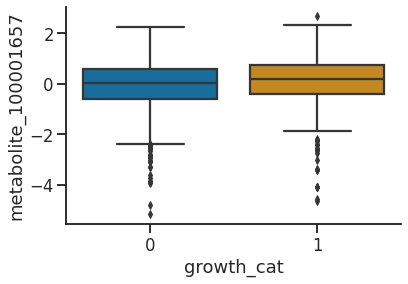

In [46]:
sns.boxplot(x='growth_cat',y='metabolite_100001657',data=metabolites_merged)

In [45]:
# tests.to_csv("metabolome_tests.csv", index=False)  # uncomment to save the result
tests.sort_values(by="q").head(20)

,feature,beta,se,t_statistic,p,n,q,CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM
1062,metabolite_999946461,0.322293,0.069642,4.666196,0.000004,818.0,0.004596,999946461,NaN,NaN,X - 16124,NaN,NaN,NaN,NaN
534,metabolite_100002488,-0.184034,0.049334,-3.708634,0.000215,1661.0,0.084532,100002488,Secondary Bile Acid Metabolism,Lipid,isoursodeoxycholate,78919-26-3,C17662,HMDB00686,127601.0
432,metabolite_100001657,0.182064,0.049912,3.656142,0.000264,1679.0,0.084532,100001657,Secondary Bile Acid Metabolism,Lipid,glycolithocholate sulfate*,15324-64-8,C11301,HMDB02639,72222.0
1068,metabolite_999946510,0.200885,0.055362,3.754637,0.000181,1400.0,0.084532,999946510,NaN,NaN,X - 12544,NaN,NaN,NaN,NaN
1153,metabolite_999947417,-0.160891,0.048366,-3.330396,0.000886,1679.0,0.227017,999947417,NaN,NaN,X - 22162,NaN,NaN,NaN,NaN
433,metabolite_100001658,0.162699,0.049682,3.255827,0.001154,1656.0,0.246283,100001658,Secondary Bile Acid Metabolism,Lipid,taurolithocholate 3-sulfate,64936-83-0,C03642,HMDB02580,440071.0
1266,metabolite_999952877,-0.149667,0.048576,-3.096789,0.001989,1645.0,0.267265,999952877,NaN,NaN,X - 24556,NaN,NaN,NaN,NaN
314,metabolite_100001237,-0.755302,0.224930,-3.300939,0.001681,62.0,0.267265,100001237,Polypeptide,Peptide,"bradykinin, hydroxy-pro(3)",37642-65-2,NaN,HMDB11728,169947.0
34,metabolite_250,-0.147290,0.047449,-3.082456,0.002086,1686.0,0.267265,250,Hemoglobin and Porphyrin Metabolism,Cofactors and Vitamins,biliverdin,55482-27-4;55482-27-4,C00500,HMDB01008,5353439.0
1227,metabolite_999949529,-0.224850,0.071776,-3.094749,0.002050,693.0,0.267265,999949529,NaN,NaN,X - 23652,NaN,NaN,NaN,NaN


## Clinical labs

In [17]:
# Find the features
chems = get_snapshot("chemistries", clean=True).sort_values(by="days_in_program")
chem_features = chems.columns[12:]  # inspect the table to find out where the metadata ends 
chems.days_in_program = chems.days_in_program.astype("float64")

# Merge with measure
chems_merged = pd.merge_asof(
    measure, chems, 
    by="public_client_id", 
    on="days_in_program", 
    direction="nearest", 
    tolerance=30.0).dropna(subset=chem_features, how="all")
chem_features = chems.columns[chems.columns.isin(chem_features)]

# Filter uncomplete
bad = chems_merged[chem_features].isnull().sum() / chems_merged.shape[0] > 0.25
chem_features = bad[~bad].index
chems_merged = chems_merged.drop(columns=bad[bad].index)

# We don't transform the values further since some of them are integer etc. and they have associated units we don't want to break
# However, that mean we can't compare the beta values between features.

In [ ]:
chems_merged

Looks pretty concise this way and we can start to run the testing loop again.

In [18]:
args = chem_features
df = chems_merged  # don't forget to reassign those
results = map(get_results, args)
results = list(results)
tests_chems = pd.concat(results)
tests_chems=tests_chems.iloc[:,:-1].dropna()
tests_chems["q"] = multipletests(tests_chems.p, method="fdr_bh")[1]

In [19]:
tests_chems

,feature,beta,se,t_statistic,p,q
A_G_RATIO,A_G_RATIO,-0.023127,0.009315,-2.511810,0.012050,0.105441
ALAT__SGPT_,ALAT__SGPT_,-0.104661,0.414365,-0.249541,0.802955,0.917536
ALBUMIN,ALBUMIN,-0.001359,0.008228,-0.163179,0.870386,0.937339
ALKALINE_PHOSPHATASE,ALKALINE_PHOSPHATASE,0.789211,0.618241,1.301759,0.193074,0.707961
ARACHIDONIC_ACID,ARACHIDONIC_ACID,-0.021631,0.063505,-0.344871,0.730209,0.917536
...,...,...,...,...,...,...
Triglyceride_HDL_Ratio,Triglyceride_HDL_Ratio,0.085964,0.050609,1.648230,0.099384,0.409228
UREA_NITROGEN,UREA_NITROGEN,-0.236864,0.119881,-2.003330,0.045209,0.232638
URIC_ACID,URIC_ACID,-0.016886,0.033994,-0.503370,0.614732,0.860625
VITAMIN_D__25_OH_TOT,VITAMIN_D__25_OH_TOT,-1.057680,0.458970,-2.289087,0.022126,0.154884


In [20]:
anns = get_snapshot("chemistries_metadata")
anns["feature"] = anns.Name
tests_chems = pd.merge(tests_chems, anns, on="feature")

In [21]:
tests_chems.sort_values(by="q").head(10)

,feature,beta,se,t_statistic,p,q,Name,Display Name,Labcorp ID,Labcorp Name,Labcorp LOINC ID,Labcorp LOINC Name,Quest ID,Quest Name,Quest LOINC ID
19,MCH,-0.228324,0.058794,-3.939792,0.000083,0.005810,MCH,Mean Corpuscular Hemoglobin,15073.0,MCH,785-6,Erythrocyte mean corpuscular hemoglobin,MCH,MCH,785-6
13,HEMOGLOBIN,-0.122272,0.033325,-3.706211,0.000213,0.007467,HEMOGLOBIN,Hemoglobin,5041.0,Hemoglobin,718-7,Hemoglobin,HG9,HEMOGLOBIN,718-7
10,GLOBULIN,0.035275,0.010711,3.343405,0.000835,0.019487,GLOBULIN,Globulin,12039.0,"Globulin, Total",10834-0,Globulin,XGL,GLOBULIN,10834-0
21,MCV,-0.486052,0.155311,-3.168465,0.001544,0.027029,MCV,Mean Corpuscular Volume,15065.0,MCV,787-2,Erythrocyte mean corpuscular volume,MCV,MCV,787-2
12,HEMATOCRIT,-0.278993,0.093052,-3.028501,0.002474,0.034637,HEMATOCRIT,Hematocrit,5058.0,Hematocrit,4544-3,Hematocrit,HCT,HEMATOCRIT,4544-3
20,MCHC,-0.076685,0.030393,-2.549950,0.010812,0.105441,MCHC,Mean Corpuscular Hemoglobin Concentration,15081.0,MCHC,786-4,Erythrocyte mean corpuscular hemoglobin concen...,CHC,MCHC,786-4
26,RDW,0.057059,0.027461,2.122202,0.033885,0.215629,RDW,Red Blood Cell Distribution Width,105007.0,RDW,788-0,Erythrocyte distribution width,RDW,RDW,788-0
1,BASOPHILS,-0.034000,0.017069,-1.991219,0.046528,0.232638,BASOPHILS,Basophils,15156.0,Basos,706-2,Basophils/100 leukocytes,DNN,BASOPHILS,706-2
22,MONOCYTES,-0.089372,0.065612,-1.340851,0.180048,0.700187,MONOCYTES,Monocytes,15131.0,Monocytes,5905-5,Monocytes/100 leukocytes,DJN,MONOCYTES,5905-5
23,OMEGA_3_TOTAL,-0.051986,0.052816,-0.978821,0.327736,0.740049,OMEGA_3_TOTAL,Omega-3 total,817653.0,Omega-3 total,35178-3,Fatty acids.omega 3,NaN,NaN,NaN


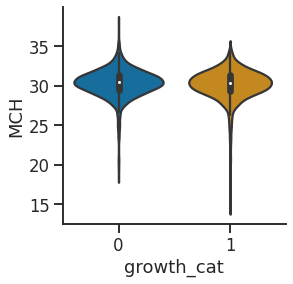

<Figure size 432x288 with 0 Axes>

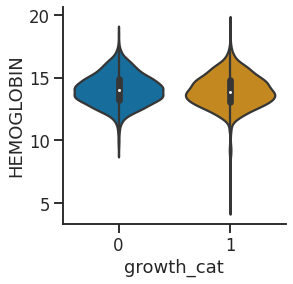

<Figure size 432x288 with 0 Axes>

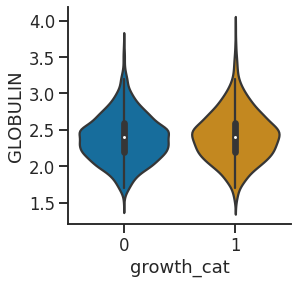

<Figure size 432x288 with 0 Axes>

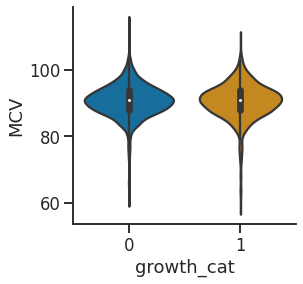

<Figure size 432x288 with 0 Axes>

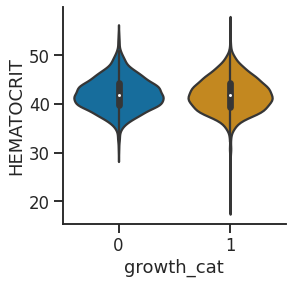

<Figure size 432x288 with 0 Axes>

In [145]:
for i in tests_chems.sort_values(by="q").head(10).index:
    q= tests_chems.loc[i,'q']
    chem =tests_chems.loc[i,'feature']
    if q <= 0.1:
        plt.figure(figsize=(4,4))
        sns.violinplot(x='growth_cat',y=chem,data=chems_merged)
        plt.show()
        plt.clf()

## Questionnaires


In [56]:
qs = get_snapshot("assessments", clean=True).sort_values(by="days_in_program")
q_features = qs.columns[8:]
q_features = q_features[q_features.str.endswith("_enum") | q_features.str.endswith("_int")]
qs.days_in_program = qs.days_in_program.astype("float64")

# Merge with measure
qs_merged = pd.merge_asof(
    measure, qs.dropna(subset=["days_in_program"]), 
    by="public_client_id", 
    on="days_in_program", 
    direction="nearest", 
    tolerance=30.0).dropna(subset=q_features, how="all")
q_features = qs.columns[qs.columns.isin(q_features)]

# Filter uncomplete
bad = qs_merged[q_features].isnull().sum() / qs_merged.shape[0] > 0.25
q_features = bad[~bad].index
qs_merged = qs_merged.drop(columns=bad[bad].index)

# The data is all categorical so we will make it ordinal now
qs_merged[q_features] = qs_merged[q_features].apply(lambda x: x.str.split("\\(|\\)").str[1]).astype("float64")
qs_merged

,diversity_shannon,vendor_observation_id,public_client_id,days_in_program,vendor_dashboard,sex,age,BMI_CALC,compartments,growth_rate,...,assessment_productivity_recent_ailments_anxiety,assessment_productivity_recent_ailments_depression,assessment_productivity_hours_missed_from_illness_real,assessment_productivity_hours_worked_real,assessment_lifestyle_avg_stress_enum,assessment_lifestyle_stress_management_enum,assessment_pss_four_item_going_your_way_enum,assessment_pss_four_item_handle_problems_enum,assessment_pss_four_item_insurmountable_enum,assessment_pss_four_item_out_of_control_enum
0,3.870313,AV15-4372,01602320,-2.0,Second Genome,M,48.0,37.229730,Clostridioides,9.697649e-02,...,NaN,NaN,NaN,NaN,7.0,0.0,1.0,3.0,2.0,2.0
1,4.281822,AV15-3716,01228476,0.0,Second Genome,F,51.0,22.462722,Clostridioides,3.016348e-01,...,NaN,NaN,NaN,NaN,4.0,0.0,2.0,0.0,1.0,1.0
2,3.818317,AV15-3627,01048590,1.0,Second Genome,F,48.0,22.459158,Clostridioides,1.295501e-03,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,3.0
3,2.999081,AV15-3759,01250245,1.0,Second Genome,M,32.0,46.955261,Clostridioides,1.423659e-06,...,NaN,NaN,NaN,NaN,7.0,0.0,3.0,2.0,2.0,3.0
4,2.496614,AV15-3489,01826852,1.0,Second Genome,F,35.0,24.541709,Clostridioides,1.624234e-01,...,NaN,NaN,NaN,NaN,6.0,0.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5070,3.354139,22001805510143,01108982,1354.0,research-microbiome,M,62.0,22.081310,Clostridioides,3.751157e-05,...,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0
5072,3.868454,22001805521073,01441946,1367.0,research-microbiome,F,44.0,19.732234,Clostridioides,4.959075e-06,...,NaN,NaN,NaN,NaN,5.0,1.0,1.0,2.0,2.0,2.0
5073,4.627451,22001805520179,01152098,1368.0,research-microbiome,F,54.0,21.077601,Clostridioides,2.813894e-01,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0
5074,4.207403,22001805510387,01023946,1371.0,research-microbiome,F,43.0,27.259184,Clostridioides,7.670708e-07,...,NaN,NaN,NaN,NaN,7.0,1.0,2.0,1.0,2.0,3.0


In [22]:
def get_results(feature):
    """Get a single association.
    
    As long as `args` and `df` are assigned this can be used on
    any data set.
    """
    formula = f"{feature} ~ + C(vendor_dashboard) + log_growth"
    fitted = ols(formula, data=df).fit()
    return pd.DataFrame({
        "feature": feature,
        "beta": fitted.params['log_growth'],
        "t_statistic": fitted.tvalues['log_growth'],
        "p": fitted.pvalues['log_growth'],
        "n": fitted.nobs
        }, index=[feature])

And we test again.

In [63]:
args = q_features
df = qs_merged  # don't forget to reassign those
results = map(get_results, track(args))
results = list(results)
tests_qs = pd.concat(results)
tests_qs["q"] = multipletests(tests_qs.p, method="fdr_bh")[1]

Output()

In [58]:
scales = qs[q_features].apply(lambda x: " | ".join(x.astype(str).sort_values().unique()) if x.dtype == "O" else "numeric")
tests_qs["scales"] = scales[tests_qs.feature].values

In [64]:
tests_qs.sort_values(by="q").head(10)

,feature,beta,t_statistic,p,n,q
assessment_lifestyle_alcohol_days_a_week_enum,assessment_lifestyle_alcohol_days_a_week_enum,-0.019156,-2.516863,0.011892,3014.0,0.529959
assessment_satisfaction_not_optimistic_enum,assessment_satisfaction_not_optimistic_enum,-0.019140,-2.402835,0.016329,3024.0,0.529959
assessment_lifestyle_cruciferous_vegetables_enum,assessment_lifestyle_cruciferous_vegetables_enum,0.012156,2.269701,0.023293,3171.0,0.529959
assessment_lifestyle_childer_enum,assessment_lifestyle_childer_enum,-0.014691,-2.208341,0.027292,3182.0,0.529959
assessment_lifestyle_sugary_drinks_enum,assessment_lifestyle_sugary_drinks_enum,0.008675,2.151080,0.031545,3180.0,0.529959
assessment_lifestyle_tabacco_enum,assessment_lifestyle_tabacco_enum,0.003002,1.839833,0.065886,3187.0,0.553441
assessment_lifestyle_vigorous_activity_duration_enum,assessment_lifestyle_vigorous_activity_duratio...,-0.021240,-1.973835,0.048487,3184.0,0.553441
assessment_digestion_vomiting_enum,assessment_digestion_vomiting_enum,-0.001591,-1.956472,0.050512,2713.0,0.553441
assessment_digestion_medications_enum,assessment_digestion_medications_enum,0.010430,1.893272,0.058428,2710.0,0.553441
assessment_vitals_adopted_enum,assessment_vitals_adopted_enum,0.001733,1.851841,0.064151,2894.0,0.553441


In [79]:
df = qs_merged
formula = f"age ~ log_growth + C(vendor_dashboard)"
fitted = ols(formula, data=df).fit()
pd.DataFrame({
        "feature": 'age',
        "beta": fitted.params['log_growth'],
        "t_statistic": fitted.tvalues['log_growth'],
        "p": fitted.pvalues['log_growth'],
        "n": fitted.nobs
        }, index=['age'])

,feature,beta,t_statistic,p,n
age,age,-0.016711,-0.242573,0.80835,3613.0


In [80]:
df = qs_merged
formula = f"BMI_CALC ~ log_growth + C(vendor_dashboard)"
fitted = ols(formula, data=df).fit()
pd.DataFrame({
        "feature": 'BMI_CALC',
        "beta": fitted.params['log_growth'],
        "t_statistic": fitted.tvalues['log_growth'],
        "p": fitted.pvalues['log_growth'],
        "n": fitted.nobs
        }, index=['BMI_CALC'])

,feature,beta,t_statistic,p,n
BMI_CALC,BMI_CALC,-0.020554,-0.611902,0.540641,3613.0


In [85]:
df = qs_merged
formula = f"log_growth ~ C(sex) + C(vendor_dashboard)"
fitted = ols(formula, data=df).fit()
pd.DataFrame({
        "feature": 'sex',
        "beta": fitted.params['C(sex)[T.M]'],
        "t_statistic": fitted.tvalues['C(sex)[T.M]'],
        "p": fitted.pvalues['C(sex)[T.M]'],
        "n": fitted.nobs
        }, index=['sex'])

,feature,beta,t_statistic,p,n
sex,sex,0.040016,0.390276,0.696356,3613.0


In [3]:
coefs = pd.read_csv('Arivale_coefs.csv',index_col=0)
coefs

,feature,beta,se,t_statistic,p,n,q,CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,...,PUBCHEM,Name,Display Name,Labcorp ID,Labcorp Name,Labcorp LOINC ID,Labcorp LOINC Name,Quest ID,Quest Name,Quest LOINC ID
1062,X - 16124,0.322293,0.069642,4.666196,0.000004,818.0,0.004596,999946461.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,isoursodeoxycholate,-0.184034,0.049334,-3.708634,0.000215,1661.0,0.084532,100002488.0,Secondary Bile Acid Metabolism,Lipid,...,127601.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,glycolithocholate sulfate*,0.182064,0.049912,3.656142,0.000264,1679.0,0.084532,100001657.0,Secondary Bile Acid Metabolism,Lipid,...,72222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,MCH,-0.228324,0.058794,-3.939792,0.000083,3846.0,0.005810,NaN,NaN,NaN,...,NaN,MCH,Mean Corpuscular Hemoglobin,15073.0,MCH,785-6,Erythrocyte mean corpuscular hemoglobin,MCH,MCH,785-6
13,HEMOGLOBIN,-0.122272,0.033325,-3.706211,0.000213,3846.0,0.007467,NaN,NaN,NaN,...,NaN,HEMOGLOBIN,Hemoglobin,5041.0,Hemoglobin,718-7,Hemoglobin,HG9,HEMOGLOBIN,718-7
10,GLOBULIN,0.035275,0.010711,3.343405,0.000835,4009.0,0.019487,NaN,NaN,NaN,...,NaN,GLOBULIN,Globulin,12039.0,"Globulin, Total",10834-0,Globulin,XGL,GLOBULIN,10834-0
21,MCV,-0.486052,0.155311,-3.168465,0.001544,3846.0,0.027029,NaN,NaN,NaN,...,NaN,MCV,Mean Corpuscular Volume,15065.0,MCV,787-2,Erythrocyte mean corpuscular volume,MCV,MCV,787-2
12,HEMATOCRIT,-0.278993,0.093052,-3.028501,0.002474,3846.0,0.034637,NaN,NaN,NaN,...,NaN,HEMATOCRIT,Hematocrit,5058.0,Hematocrit,4544-3,Hematocrit,HCT,HEMATOCRIT,4544-3


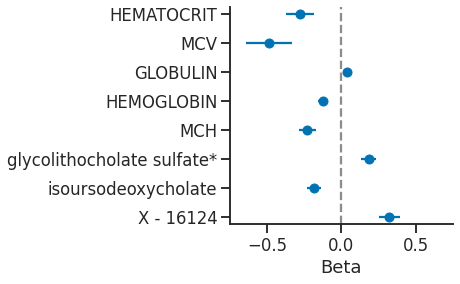

In [7]:
plt.figure(figsize=(4,4))
plt.errorbar(coefs['beta'],range(len(coefs['feature'])),xerr=coefs['se'],marker='o',fmt=' ')
plt.xlim(-.75,.75)
plt.plot((0,0),(-0.25,7.25),'k--',alpha=0.5)
plt.ylim(-.25,7.25)
yticks=plt.yticks(range(len(coefs['feature'])),coefs['feature'])
plt.xlabel('Beta')
plt.savefig('Arivale-Coefs.pdf',bbox_inches='tight')

In [34]:
merged=pd.merge(metabolites_merged,chems_merged,on=['public_client_id','days_in_program'])
merged

,diversity_shannon_x,vendor_observation_id,public_client_id,days_in_program,vendor_dashboard_x,sex_x,age_x,BMI_CALC_x,compartments_x,growth_rate_x,...,RED_CELL_COUNT,SODIUM,TOTAL_NEUTROPHILS,TOTAL_NEUTROPHILS_AB,TRIGLYCERIDES,Triglyceride_HDL_Ratio,UREA_NITROGEN,URIC_ACID,VITAMIN_D__25_OH_TOT,WHITE_CELL_COUNT
0,4.542282,AV15-3636,01447446,1.0,Second Genome,F,56.0,21.950816,Clostridioides,1.022228e-07,...,4.67,142.0,36.0,1.50,70.0,0.769231,12.0,4.2,29.2,4.0
1,4.403993,AV15-1094,01789546,1.0,Second Genome,F,87.0,18.692937,Clostridioides,1.670734e-01,...,4.10,130.0,69.5,3.75,52.0,0.481481,17.0,5.1,70.0,5.4
2,3.318960,AV15-3588,01949838,1.0,Second Genome,F,32.0,25.328546,Clostridioides,1.382353e-06,...,4.67,142.0,51.0,3.20,50.0,0.555556,9.0,4.9,9.3,6.3
3,4.283908,AV15-1295,01421882,1.0,Second Genome,F,19.0,23.793846,Clostridioides,1.810336e-01,...,4.10,142.0,61.7,4.17,74.0,1.423077,10.0,4.8,20.0,6.8
4,4.278019,AV15-1348,01306924,1.0,Second Genome,M,56.0,26.541837,Clostridioides,1.358488e-02,...,4.80,142.0,61.4,2.05,42.0,0.518519,17.0,6.6,36.0,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,3.684504,AV15-2674,01801678,453.0,Second Genome,M,35.0,20.705900,Clostridioides,7.248393e-07,...,4.34,141.0,64.0,2.90,46.0,0.741935,19.0,6.8,78.0,4.5
1772,2.850451,AV15-2217,01874590,463.0,Second Genome,M,36.0,21.558261,Clostridioides,2.416004e-01,...,5.00,141.0,63.0,4.20,122.0,4.066667,9.0,5.2,21.6,6.7
1773,3.914202,22001805511808,01941857,509.0,research-microbiome,M,54.0,22.148708,Clostridioides,2.970213e-01,...,5.37,140.0,65.0,4.60,58.0,1.017544,19.0,5.3,42.3,7.1
1774,4.352964,22001612561459,01524770,517.0,research-microbiome,F,53.0,21.797160,Clostridioides,2.880267e-01,...,4.33,143.0,41.0,1.70,82.0,1.154930,6.0,4.0,45.8,4.1


In [60]:
df=merged.loc[:,list(coefs.feature.values)+['sex_x','age_x','BMI_CALC_x','growth_cat_x','vendor_dashboard_x','log_growth_x']]
df

formula = f"C(growth_cat_x)  ~ C(sex_x) + C(vendor_dashboard_x) + BMI_CALC_x + age_x + metabolite_100002488 + metabolite_100001657 + metabolite_100001658 + MCH + HEMOGLOBIN + GLOBULIN + MCV + HEMATOCRIT"
fitted = ols(formula, data=df).fit()
fitted

ValueError: endog has evaluated to an array with multiple columns that has shape (1497, 2). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [58]:
fitted.rsquared #with sex, vendor, bmi calc

0.04911131448162043